<a href="https://colab.research.google.com/github/OiBoii/cornell-cs5785-ml/blob/master/Midterm%20DSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DSP - Midterm 
## DTMF + Goertzel Algorithm
Omer Ifrach (oi38)



In [1]:
import numpy as np
from scipy.io import wavfile
import seaborn as sb
import pandas as pd

In [2]:
# obtains wav sample rate (8000Hz) & data (array of magitudes magnitude)
samplerate, data = wavfile.read('mystery.wav')
N = 205
fs = np.array([697, 770, 852, 941, 1209, 1336, 1477, 1633])

print(f"""Data:
--------------------------------------------------------------------------
Standard bin size:   N = {N} Samples
--------------------------------------------------------------------------
Sampling Frequency:  {samplerate}Hz
--------------------------------------------------------------------------
Sampling Data:       {data}
--------------------------------------------------------------------------
Frequency Values:    {fs}
--------------------------------------------------------------------------

""")


Data:
--------------------------------------------------------------------------
Standard bin size:   N = 205 Samples
--------------------------------------------------------------------------
Sampling Frequency:  8000Hz
--------------------------------------------------------------------------
Sampling Data:       [  4348   2748   1436 ... -10364  -5628   -180]
--------------------------------------------------------------------------
Frequency Values:    [ 697  770  852  941 1209 1336 1477 1633]
--------------------------------------------------------------------------




In [4]:
# Gortzel's Algortihm: takes sample (N samples values, k values)
def goertzel(bin_data, k):
    # initializing intermediate values of s[n]
    sn1 = 0 
    sn2 = 0
    
    # coefficients branching from s[n-1]
    cf1 = 2 * np.cos(2 * np.pi * k / len(bin_data))
    cf2 = -1 * np.exp(-2 * np.pi * k / len(bin_data))

    yn1 = 0  # initialize final output y[n-1]
    a = 0.95 # signal 'damper' for low pass filter 
    
    # looping through bin samples
    for i in range(len(bin_data)):
  
        sn = bin_data[i] + cf1 * sn1 - sn2 # current sample
        sn2 = sn1 # second shift
        sn1 = sn # first shift
        yn = sn + cf2 * sn1 # Gortzel's output
        
        # squaring the Goertzel output y[n] to ensure positive value
        temp_power = np.abs(yn)**2 
    
        # first order filter: damp current n & sum with weighted sample average
        power = (1 - a) * temp_power + a * yn1
       
        yn1 = power  

    return power


In [5]:
# splitting samples into N-sized bins
def split_beans(data, N):
    base_N = 205 # ensures same starting points for all N sizes
    n_bins = 1 + (len(data)-N) // (base_N) # accounts for last offset
    num_of_samples = n_bins * (base_N-1) + N # total samples taken from data set

    sampled_data = data[:num_of_samples]
    bins = [sampled_data[i : i + N] for i in range(0, num_of_samples, base_N)]

    return bins

In [6]:
# determine the coefficient of each k for every bin
def goertzeling(N_size, frequencies):
    k_vals = np.rint((frequencies * N_size) / samplerate) # calculate ks
    bins = split_beans(data, N_size) # divide sample into N-sized bins
    k_powers = fs_sweep(bins, k_vals, N_size) # exe gortzel for each k
    return k_powers

In [7]:
# Perform Goertzel's Algorithm for each k for each bin
def fs_sweep(bins, ks, N_size):
    scan = []
    for k in ks: # For every k in the list of ks
        k_scan = [] 
        for b in bins: # For every bin in the list of bins
            power = goertzel(b, k) # Record the result of Goertzel filter
            k_scan.append(power)
        scan.append(k_scan)
    scan = np.array(scan) # Turn list into numpy array
    return scan

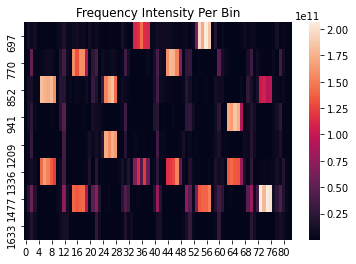

In [8]:
# Visualizing frequency intensity per bin (credit: Eli Russos)
fs_gortzel = goertzeling(N, fs)
fs_map = sb.heatmap(fs_gortzel, yticklabels=fs).set_title("Frequency Intensity Per Bin")

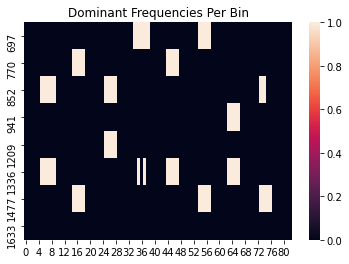

In [9]:
# Thresholding values and using boolean to expose the potential touchtones
threshold =  10 ** 11
fs_truth_table = fs_gortzel > threshold
fs_truth_map = sb.heatmap(fs_truth_table, yticklabels=fs).set_title("Dominant Frequencies Per Bin")

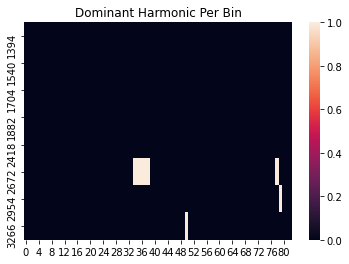

In [12]:
# repeating visualization for harmonic frequecies 
N2 =210
hfs = fs*2
threshold =   10 ** 11

# identifying harmonic noise
h_goertzel = goertzeling(N2, hfs)
h_truth_table = h_goertzel > threshold
h_truth_map = sb.heatmap(h_truth_table, yticklabels=hfs).set_title("Dominant Harmonic Per Bin")

In [13]:
# truth table for touchtone keys (credit: Eli Russos)

numpad_map = {
# 697   770    852    941   1209   1336   1477   1633
(True, False, False, False, True, False, False, False) : "1",
(True, False, False, False, False, True, False, False) : "2",
(True, False, False, False, False, False, True, False) : "3",
(True, False, False, False, False, False, False, True) : "A",

(False, True, False, False, True, False, False, False) : "4",
(False, True, False, False, False, True, False, False) : "5",
(False, True, False, False, False, False, True, False) : "6",
(False, True, False, False, False, False, False, True) : "B",

(False, False, True, False, True, False, False, False) : "7",
(False, False, True, False, False, True, False, False) : "8",
(False, False, True, False, False, False, True, False) : "9",
(False, False, True, False, False, False, False, True) : "C",

(False, False, False, True, True, False, False, False) : "*",
(False, False, False, True, False, True, False, False) : "0",
(False, False, False, True, False, False, True, False) : "#",
(False, False, False, True, False, False, False, True) : "D",
}

# transposing table so that time is on x-axis [n, k]
fs_truth_table = fs_truth_table.T  
h_truth_table = h_truth_table.T 

In [14]:

phone_number = '' 

temp = None  # previous value

for t in range(len(fs_truth_table)):
    # identifying truth table patterns to assign numeric / null value.
    num = numpad_map.get(tuple(fs_truth_table[t]), None)
    
    # if a number was identified and the previous value is none - add to phone number
    if num != None and temp == None:
       
        # Check whether second harmonic is present
        both_true = np.logical_and(fs_truth_table[t], h_truth_table[t])
       
        if not both_true.any():
            phone_number += num # Valid key press gets recorded
    
    temp = num
    
print(phone_number)
# print("Eight-Six-Seven-Five-Three-O'-Na-ee-aa-iiin")

8675309
